# Simple seismic modeling

The seismic modeling functionality built into *blixt_rp* is very simple, but at the same time powerful.

Here you have the possibility to create 1D and quasi-2D models either from manual input, or using the statistics and depth trends calculated earlier (*run half-space_avo.ipynb* and *Calculate depth trends.ipynb*).

So lets see at some of the possibilities.

Import the necessary python scripts, please modify the *working_dir* to the folder path that you have used in earlier notebooks

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

working_dir = 'C:\\Users\\MårtenBlixt\\PycharmProjects\\blixt_rp'

#the following two lines are only necessary when working with development versions of the code
sys.path.append('C:\\Users\\MårtenBlixt\\PycharmProjects\\blixt_rp')
sys.path.append('C:\\Users\\MårtenBlixt\\PycharmProjects\\blixt_utils')

import blixt_utils.io.io as uio
import blixt_utils.utils as bu
import blixt_rp.plotting.plot_logs as rpp
import blixt_rp.core.models as brm
import blixt_utils.misc.wavelets as bumw

We start by creating a very simple 1D model with three layers, and plot the modelled seismic as a function of incidence angle.

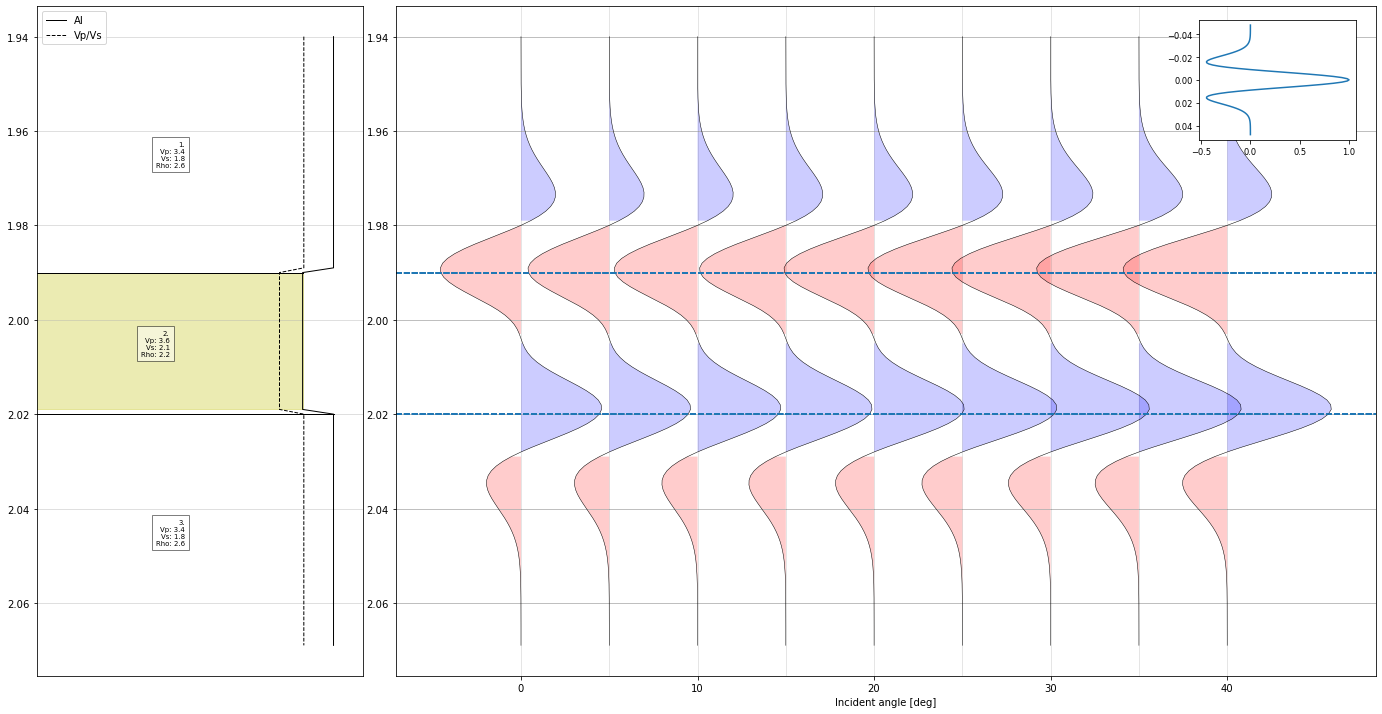

In [2]:
overburden = brm.Layer(thickness=0.05, vp=3400, vs=1820, rho=2.6)
target = brm.Layer(thickness=0.03, vp=3600, vs=2120., rho=2.2, target=True)
m = brm.Model(depth_to_top=1.94, layers=[overburden, target])  # depth_to_top is TWT in seconds
# add a base by appending a copy of the overburden
m.append(overburden)

# and plot the model with incident dependent seismic traces using a 25Hz Ricker wavelet
sample_rate = 0.001
wavelet = bumw.ricker(0.096, sample_rate, 25)
# set up the plot
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(nrows=1, ncols=2,
                            width_ratios=[1, 3],
                            hspace=0.05, wspace=0.05,
                            left=0.05, bottom=0.03, right=0.98, top=0.96)
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
m.plot(ax=ax0)
brm.plot_wiggels(m, sample_rate, wavelet, 
                 avo_angles=[0., 5.,  10. , 15., 20., 25., 30., 35., 40.], 
                 ax=ax1)

The target layer of the model can be modelled using NTG with a thin layer model:

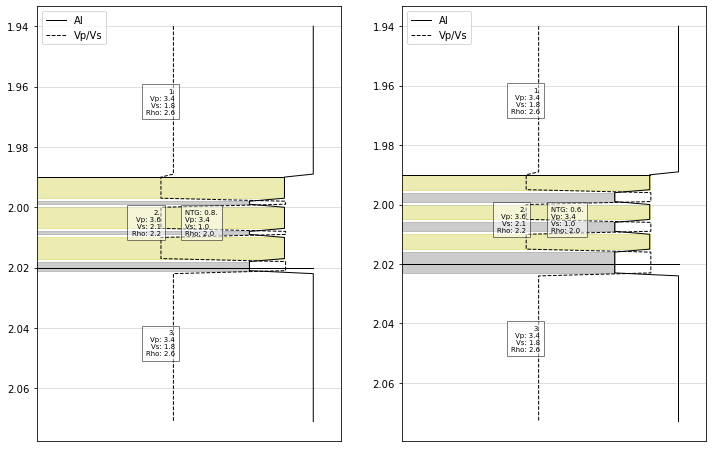

In [3]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 8))
target1 = brm.Layer(thickness=0.03, vp=3600, vs=2120., rho=2.2, ntg=0.8, target=True)
target2 = brm.Layer(thickness=0.03, vp=3600, vs=2120., rho=2.2, ntg=0.6, target=True)
m1 = brm.Model(depth_to_top=1.94, layers=[overburden, target1]) 
m2 = brm.Model(depth_to_top=1.94, layers=[overburden, target2])
m1.append(overburden)
m2.append(overburden)
m1.plot(ax=axs[0])
m2.plot(ax=axs[1])

When calculating the seismic response from such a target, the option *voigt_reuss_hill=True*, in the *realize_model* method of the model, will give a faster and still realistic results when it comes to modeling the effect of various NTG. 

In the examples below, we will use the results from *run half-space_avo.ipynb*, which stored averages of the fluid substituted rock properties in *SumsAndAverages_fs.xlsx*. 

So we begin by reading those results

In [3]:
rokdoc_output=os.path.join(working_dir, 'results_folder', 'SumsAndAverages_fs.xlsx')
sums = uio.read_sums_and_averages(rokdoc_output)

Now we can build two, quasi-2D, wedge models. One with brine filled target and one with the fluid substituted version of the target.

To create a quasi-2D model, we need an index parametrizing the lateral variation. Lets set it to contain 51 steps 

In [4]:
n_traces = 51
top_layer_thickness = 0.08

for a wedge model to work, we need to counterweight the changing thickness of one layer with an extra layer so that the total height of the model is kept constant

In [5]:
def wedge(i):
    return 0.1 - 0.1/(n_traces-1) * i

def reverse_wedge(i):
    return 0.06 + 0.1/(n_traces-1) * i

And by using these wedges we can build two wedge models; one for the dry (brine) case and one for the fluid substituted (oil) case 

In [6]:
overburden = brm.Layer(
    thickness=top_layer_thickness, 
    vp=sums['Shale C_shale']['VpMedian'],
    vs=sums['Shale C_shale']['VsMedian'],
    rho=sums['Shale C_shale']['RhoMedian'],
)
target_fs = brm.Layer(
    thickness=wedge,    
    vp=sums['Sand E_sand_fs']['VpMedian'],
    vs=sums['Sand E_sand_fs']['VsMedian'],
    rho=sums['Sand E_sand_fs']['RhoMedian'] 
    )
target_dry = brm.Layer(
    thickness=wedge,    
    vp=sums['Sand E_sand_dry']['VpMedian'],
    vs=sums['Sand E_sand_dry']['VsMedian'],
    rho=sums['Sand E_sand_dry']['RhoMedian'] 
    )
base = brm.Layer(
    thickness=reverse_wedge, 
    vp=sums['Shale C_shale']['VpMedian'],
    vs=sums['Shale C_shale']['VsMedian'],
    rho=sums['Shale C_shale']['RhoMedian'],
)             
m_fs = brm.Model(
    depth_to_top=1.4,
    layers=[overburden, target_fs, base],
    trace_index_range=np.arange(n_traces)
)
m_dry = brm.Model(
    depth_to_top=1.4,
    layers=[overburden, target_dry, base],
    trace_index_range=np.arange(n_traces)
) 

First we can have a look at the models at one given trace position

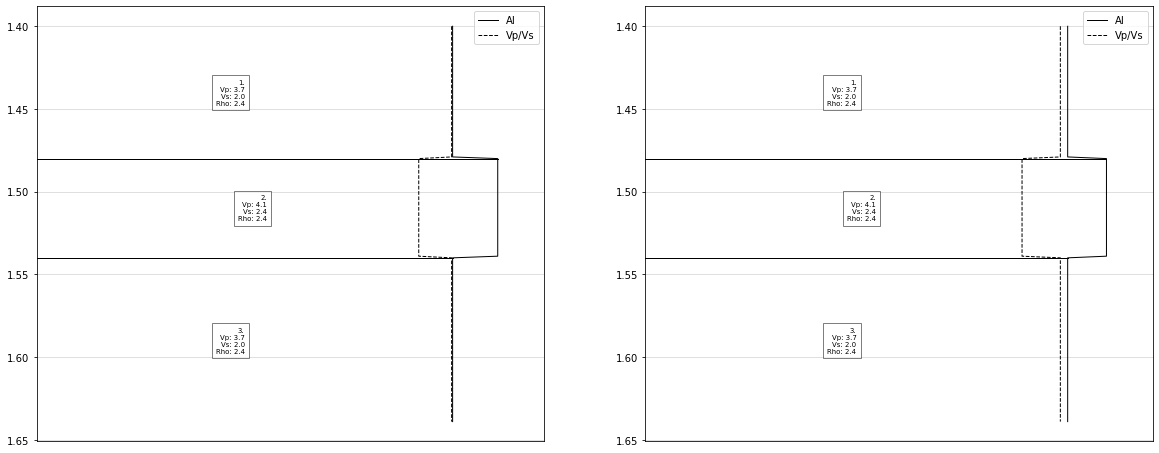

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))
m_dry.plot(axs[0], 20)
m_fs.plot(axs[1], 20)

Now lets plot modelled seismic for the wedge model for vertical incident waves, using the same Ricker wavelet as above

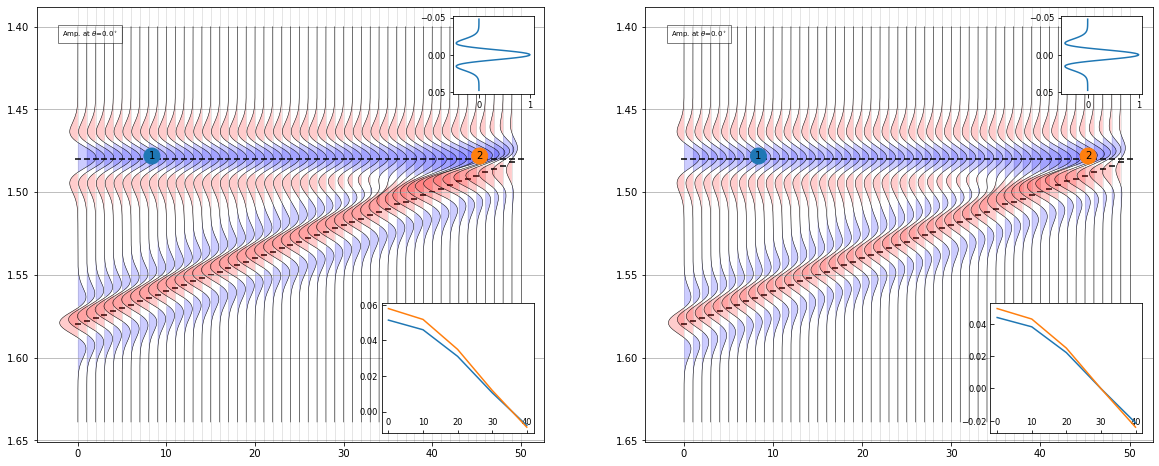

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))
brm.plot_wiggels(m_dry, sample_rate, wavelet, angle=0., eei=False, extract_avo_at=[(8, 1.48), (45, 1.48)], ax=axs[0])
brm.plot_wiggels(m_fs, sample_rate, wavelet, angle=0., eei=False, extract_avo_at=[(8, 1.48), (45, 1.48)], ax=axs[1])